In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt

from commplax import util, optim
from gdbp import gdbp_base as gb, data as gdat, aux

data_train = gdat.load(1, 0, 4, 2)[0]
data_test = gdat.load(2, 0, 4, 2)[0]

# train
def train_gdbp(data, dtaps=261, ntaps=41, meta='NN', renew_state=True, init_len=4000):
  # sparam_keys = [('fdbp_0',)] 
  sparam_keys = [('fdbp_0',), ('RConv',)] 
  gdbp = gb.model_init(data, {'ntaps': 1, 'dtaps': dtaps, 'init_fn': gb.fdbp_init(data.a, xi=1.1, steps=3)},sparam_keys ,meta=meta,init_len=init_len)
  return list(zip(*list(gb.train(gdbp, data, n_iter=2000, opt = optim.sgd(optim.piecewise_constant([500, 1000], [2e-5, 1e-5, 1e-6])), renew_state=renew_state))))

In [2]:
loss_gdbp, params, state = train_gdbp(data_train, meta='NN', renew_state=True)

In [5]:
params[100]

FrozenDict({})

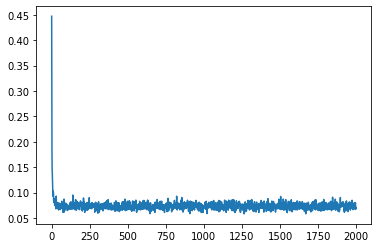

In [6]:
plt.plot(loss_gdbp[:2000])

In [ ]:
loss_gdbp, params, state = train_gdbp(data_train, meta='NN', renew_state=True)
loss_gdbp1, params1, state1 = train_gdbp(data_train, meta='NN', renew_state=False, init_len=4000)
# loss_gdbp2, params2, state2 = train_gdbp(data_train, meta=False, renew_state=False, init_len=8000)
loss_gdbp3, params3, state3 = train_gdbp(data_train, meta='meta', renew_state=False)
loss_gdbp4, params4, state4 = train_gdbp(data_train, meta='meta', renew_state=True)
loss_gdbp5, params5, state5 = train_gdbp(data_train, meta='NN', renew_state=True)
loss_gdbp6, params5, state5 = train_gdbp(data_train, meta='NN', renew_state=True)

In [ ]:
plt.plot(loss_gdbp5)
plt.plot(loss_gdbp6)

In [ ]:
### 是否更新 adaptive filter : FOE + MIMOAF
plt.plot(loss_gdbp, label='renew state')
plt.plot(loss_gdbp2, label='fix state')
plt.plot(loss_gdbp3, label='meta + fix state')
plt.plot(loss_gdbp4, label='meta + renew state')
plt.legend(loc='best')

In [ ]:
## Kalman filter review


## Adaptive filter 结构解析



In [ ]:
## 加入我们的Meta 结构
# Q: (1) ML上这个问题的提法？
#    (2) Adaptive filter    vs    RNN,LSTM,Attention   (look MIMO renew, Kalman filter, RNN)
#    (3) Our Meta Construct vs attention
#    ！！！how to construct our meta net (input ??? )

In [ ]:
## Testing
# 整段 test
gb.test()

# 分段 test
#To be do

In [ ]:
## data loader
from torch.utils.data import Dataset
from commplax import xop
from torch.utils.data import DataLoader
from gdbp import gdbp_base as gb, data as gdat, aux

data_train = gdat.load(1, 0, 4, 2)[0]
data_test = gdat.load(2, 0, 4, 2)[0]

class TrainDataset(Dataset):
    def __init__(self, data_train, sps=2, mimo_len=161):
        super(TrainDataset,self).__init__()
        self.xc = (mimo_len - 1)//2
        self.sps = sps
        self.mimo_len = mimo_len
        self.x = data_train.x
        self.y = data_train.y
    
    def __getitem__(self, index):
        idx = index + self.xc
        return self.y[(idx - self.xc) * self.sps:(idx + self.xc + 1) * self.sps], self.x[idx]   ################################ fix bugs
    
    def __len__(self):
        return self.x.shape[0] - self.mimo_len + 1


def get_data_loader(data_train, batch_size=128, mimo_len=161, shuffle=False):
    train_data = TrainDataset(data_train, mimo_len=mimo_len)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=shuffle) # shuffule = False 就是顺序sample
    return train_loader

train_loader = get_data_loader(data_train,batch_size=10, mimo_len=3)
print('data loader is ready!')

In [ ]:
## CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from complex_layers import complex_conv1d 

## torch complex
import complex_layers as Cnn
import complex_functions as CF 

act = Cnn.cNL()
max_pool = Cnn.ComplexMaxPool1d
avg_pool = Cnn.ComplexAvgPool1d
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = complex_conv1d(2,2,3)
        self.pool1 = max_pool(kernel_size=2)
        self.conv2 = complex_conv1d(2,2,5)
        self.pool2 = max_pool(kernel_size=2)
        self.conv3 = complex_conv1d(2,2,3)
        self.pool3 = avg_pool(kernel_size=2)
        self.fc = complex_conv1d(2,2,38)


    def forward(self,x):
        x = act(self.pool1(self.conv1(x)))
        x = act(self.pool2(self.conv2(x)))
        x = act(self.pool3(self.conv3(x)))
        x = self.fc(x).squeeze()
        return x
net1 = CNN()        

# loss
def MSE(x,y):
    return torch.mean(torch.abs(x-y)**2)

In [ ]:
## torch complex
import complex_layers as Cnn
import complex_functions as CF 
mimo_len = 11
sps = 2
pol = 2
net2 = Cnn.ComplexLSTM(mimo_len * sps * pol, pol, 4)
train_loader = get_data_loader(data_train, batch_size=100, mimo_len=mimo_len)

def detach(state):
    return (state[0].detach(), state[1].detach())

import torch.optim as optim
optimizer = optim.Adam(params=net2.parameters(), lr=0.01)
loss_path = []
for i,(y,x) in enumerate(train_loader):
    # y: L x mimo_len * sps x pol      x: L x pol
    optimizer.zero_grad()
    L = y.shape[0]
    y = y.reshape([L,-1])  # L x Hin
    y = y.unsqueeze(1)     # L x 1 x Hin
    if i == 0:
        x_hat, state = net2(y)
    else:
        x_hat, state = net2(y, detach(state))   # x_hat: L x 1 x pol
    x_hat = x_hat.squeeze()
    loss = MSE(x_hat, x)
    loss.backward()
    optimizer.step()
    loss_path.append(loss.item())
    if i % 20 == 0:
        print(f'iter {i}: loss: {loss.item()}')
    if i == 200:
        break

In [ ]:
plt.plot(loss_path)

In [ ]:
net = nn.LSTM(2,2,2)
opt = optim.Adam(params=net.parameters(), lr=0.001)
h0 = torch.zeros(2,5,2)
c0 = torch.zeros(2,5,2)
state = (h0,c0)
# for i in range(1):
x = torch.rand(10,5,2)
y = torch.rand(10,5,2)
opt.zero_grad()
y_hat,state = net(x, state)
# loss = MSE(y,y_hat)
# loss.backward()
# opt.step()
# print(loss.item())

In [ ]:
state[0].detach()

In [ ]:
# data preprocess
from commplax import comm, xcomm, equalizer as eq, plot as cplt
cplt.scatter(data_train.y[0:2000])

In [ ]:
## Training
import torch.optim as optim
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)

Epochs = 200
loss_path = []
for i,(y,x) in enumerate(train_loader):
    # data reshape
    y = y.transpose(1,2)

    ## training
    optimizer.zero_grad()
    loss = MSE(net(y), x)
    loss.backward()
    optimizer.step()
    loss_path.append(loss.item())
    if i % 20 == 0:
        print(f'iter {i}: loss: {loss.item()}')


In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_path)